# (S)ARIMA Modelling
Exploring ARIMA/SARIMA time-forecasting for predicting quantity/sales. 

Going to start at a very high level and predict for the store as a whole but later can experiment with breaking this down by category, sub-category, or maybe even product. Through my initial research, this might require more advanced techniques due to scalability. I might want to look into global models, hieraarchial forecasting packages/methods, or more advanced time series libraries (pmdarima, prophet).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/raw/Sample-Superstore.csv", encoding='latin1',
                  parse_dates=["Order Date", "Ship Date"])

In [2]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

Datatypes pretty easy, most are strings. Converted dates to datetime when reading csv

In [4]:
print(f"{df.isnull().sum().sum()} NULL values")
print(f"{df.duplicated().sum()} duplicate rows")

0 NULL values
0 duplicate rows


### Additional Clean-up

In [5]:
if 'Country' in df.columns and df['Country'].nunique() == 1:
    df.drop(columns=["Country"], inplace=True)

# Extract useful time features
df["Order Year"] = df["Order Date"].dt.year
df["Order Month"] = df["Order Date"].dt.month
df["Order Month-Year"] = df["Order Date"].dt.to_period("M").dt.start_time
df["Ship Year"] = df["Ship Date"].dt.year
df["Ship Month"] = df["Ship Date"].dt.month
df["Ship Month-Year"] = df["Ship Date"].dt.to_period("M")

df['Profitability']=df['Profit']/df['Sales']

# Aggregate Sales/Profit/Quantity Data to Monthly

In [6]:
df_monthly = df.groupby("Order Month-Year").agg(
    Sales=('Sales', 'sum'),
    Profit=('Profit', 'sum'),
    Quantity=('Quantity', 'sum')
).reset_index()
df_monthly.set_index("Order Month-Year", inplace=True)
df_monthly.head()

,Sales,Profit,Quantity
Order Month-Year,,,
2014-01-01,14236.895,2450.1907,284
2014-02-01,4519.892,862.3084,159
2014-03-01,55691.009,498.7299,585
2014-04-01,28295.345,3488.8352,536
2014-05-01,23648.287,2738.7096,466


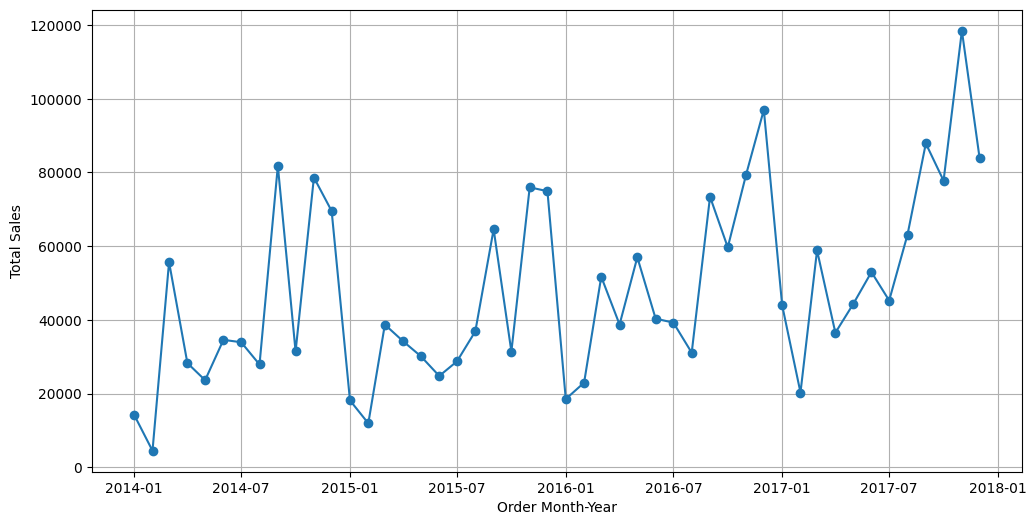

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(df_monthly["Sales"], marker='o')
plt.xlabel("Order Month-Year")
plt.ylabel("Total Sales")
plt.grid()

We may want to predict this at a more granular level but let's stick with monthly aggregation for now as I expect it is fairly simple to understand while I am learning ARIMA/SARIMA.

# Log Transformation
Common practice as sales data often grows exponentially or has increasing variance over time (Our use case). Taking the logarithm helps to:
- **Stabilize variance:** Make the variability of the data more consistent acorss different sales levels.
- **Make Relationships Linear/Additive:** Transform multiplicative relationships into additive ones which are easier for linear models like ARIMA to handle.

Been made aware of the box-cox transform as an alternative to the log-transform. General idea is the same though, try and stabilise the variance.

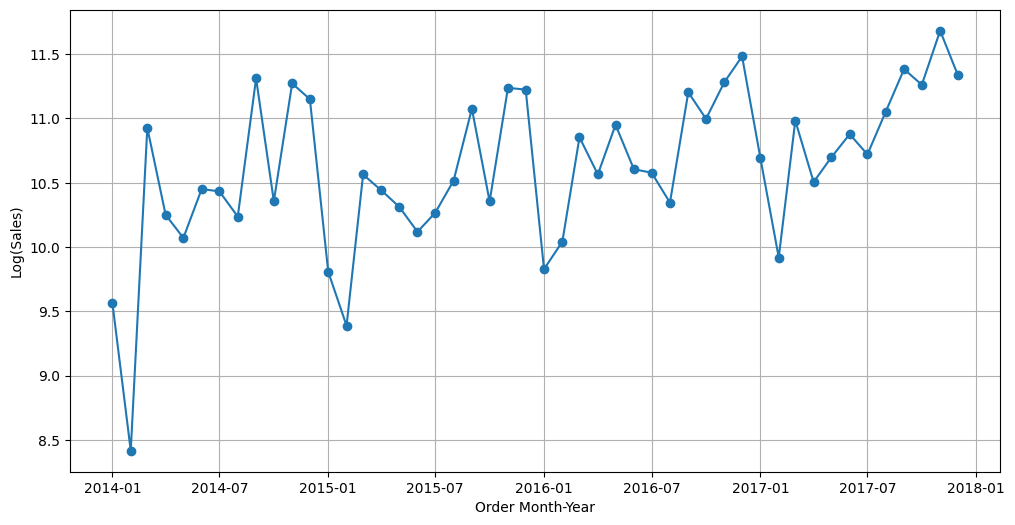

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import numpy as np

df_monthly['Log_Sales'] = np.log(df_monthly['Sales'])

plt.figure(figsize=(12, 6))
plt.plot(df_monthly["Log_Sales"], marker='o')
plt.xlabel("Order Month-Year")
plt.ylabel("Log(Sales)")
plt.grid()

Use ADF test to determine if time series is stationary. We will make ACF/PACF plots to visualise this too.

In [9]:
def adf_test(series, title='ADF Test Results'):
    print(f'--- {title} ---')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(f'{label}: {value}')
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data has no unit root and is stationary.")
    else:
        print("Weak evidence against null hypothesis, fail to reject the null hypothesis. Data has a unit root and is non-stationary.")
    print("-" * 30)

adf_test(df_monthly['Log_Sales'], title='ADF Test on Log-Transformed Sales')

--- ADF Test on Log-Transformed Sales ---
ADF Statistic: -4.932354754549927
p-value: 3.015473000827589e-05
#Lags Used: 0
Number of Observations Used: 47
Strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data has no unit root and is stationary.
------------------------------


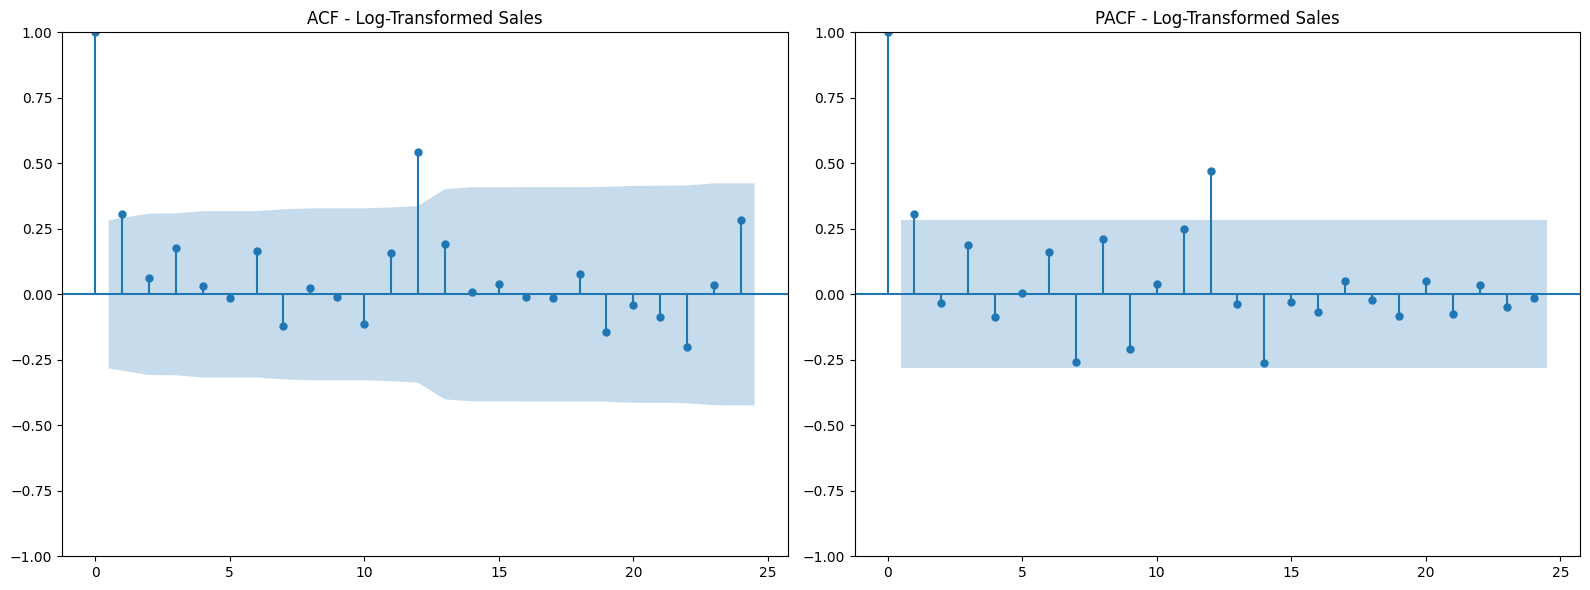

In [10]:
# ACF and PACF on Log-Transformed Sales
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(df_monthly['Log_Sales'], lags=24, ax=ax[0], title='ACF - Log-Transformed Sales') # lags=2*seasonal_period (2*12=24)
plot_pacf(df_monthly['Log_Sales'], lags=24, ax=ax[1], title='PACF - Log-Transformed Sales')
plt.tight_layout()
plt.show()

General Interpretations:
- ACF slowly decaying: Confirms a non-stationary trend, suggesting non-seasonal differencing.
- Spikes at seasonal lags (12, 24 etc.) in ACF and/or PACF: Confirms seasonality, suggesting seasonal difference (D and s=12)
- It's common for ADF tests to sometimes give misleading results or for interpretation to differ based on context and visual checks. For ARIMA, it's often safer to difference out clear trends and seasonality even if an ADF test sometimes passes on the raw or simply log-transformed data, especially with clear visual cues like yours.

Specific Interpretation of these plots/ADF test:
- Based purely on the p-value (3e-5), the ADF test technically suggests that the log-transformed series is stationary.
- Looking at the ACF plot there is still a slow decay at the initial non-seasonal lags (1, 2, 3 etc.) $\rightarrow$ Need to difference this out for ARIMA/SARIMA


# Seasonal Differencing
Use `diff(12)` as we suspect 12-monthly cycle, effectively removing the seasonal pattern from the data, making it "seasonally flat". 

In [11]:
seasonally_differenced_log_sales = df_monthly["Log_Sales"].diff(12).dropna()
print(f"Number of nulls in seasonally_differenced_log_sales: {seasonally_differenced_log_sales.isnull().sum()}")

Number of nulls in seasonally_differenced_log_sales: 0


**Checking for stationarity (ADF) test** - mean, variance, autocorrelation do not change over time. <br>
Non-stationary data can lead to misleading statistical inferences and poor forecasts. If the ADF test indicates the series is stationary after seasonal differencing, it means you've successfully removed trends and seasonality, and the remaining variation is more random, which ARIMA can model.

**Analysing Autocorrelation (ACF and PACF Plots)** <br>
- ACF: Shows the correlation of a time series with its own past values at different lags. For a stationary series, you expect the ACF to drop off relatively quickly to zero. Significant spikes at seasonal lags (e.g 12, 24 for monthly data) indicate remaining seasonality.
- PACF: Shows the correlation of a time series with its own past values at different lags, **AFTER** removing the effects of correlations at intermediate lags. It helps identify the direct relationship between an observation and a specific past observation. 

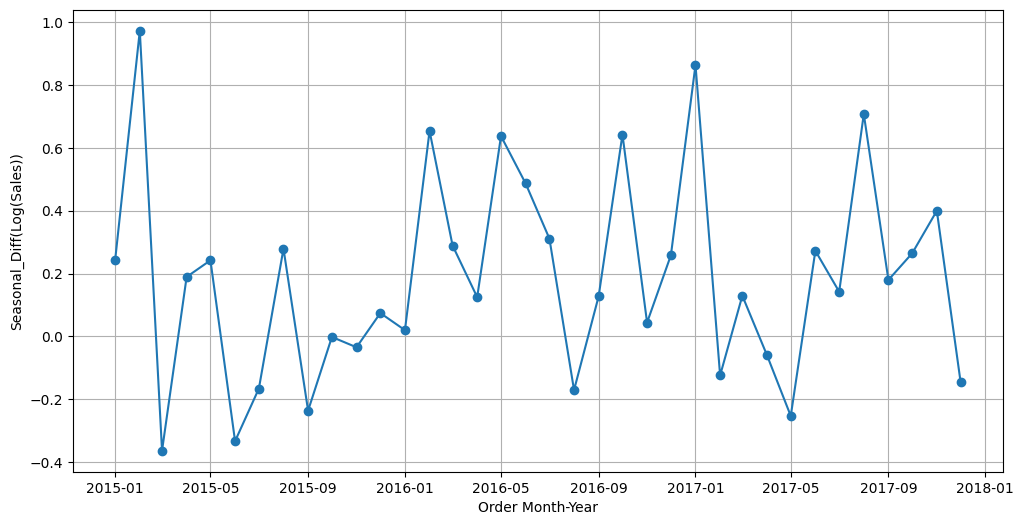

--- ADF Test on Seasonally Differenced Log Sales ---
ADF Statistic: -6.146068180416246
p-value: 7.76197043454102e-08
#Lags Used: 0
Number of Observations Used: 35
Strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data has no unit root and is stationary.
------------------------------


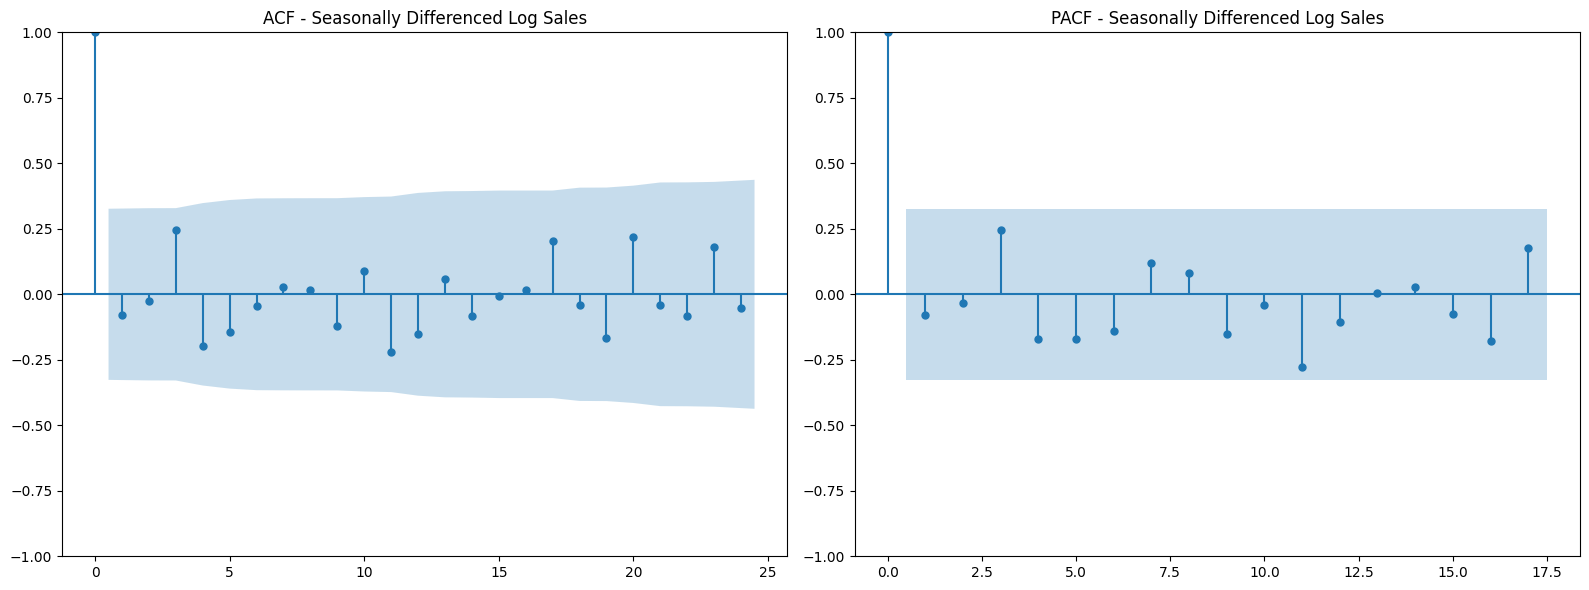

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(seasonally_differenced_log_sales.index, seasonally_differenced_log_sales, marker='o')
plt.xlabel("Order Month-Year")
plt.ylabel("Seasonal_Diff(Log(Sales))")
plt.grid()
plt.show()

adf_test(seasonally_differenced_log_sales, title='ADF Test on Seasonally Differenced Log Sales')

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(seasonally_differenced_log_sales, lags=24, ax=ax[0], title='ACF - Seasonally Differenced Log Sales')
plot_pacf(seasonally_differenced_log_sales, lags=17, ax=ax[1], title='PACF - Seasonally Differenced Log Sales') # Lags needs to be < 18 (half sample size)
plt.tight_layout()
plt.show()

In [13]:
# Typically, reserve the last 12 to 24 (1-2 seasonal cycles) months for testing
train_size = len(df_monthly) - 12
train_data = df_monthly['Log_Sales'].iloc[:train_size]
test_data = df_monthly['Log_Sales'].iloc[train_size:]

print(f"Train data length: {len(train_data)} months")
print(f"Test data length: {len(test_data)} months")

Train data length: 36 months
Test data length: 12 months


# Determine Parameters for SARIMA Modeling

`SARIMA(p, d, q)(P, D, Q)s`
- `(p, d, q)`: Non-Seasonal Orders
    - `p`: **AR(Autoregressive) order.** Look at the **PACF** plot. If there's a sharp drop-off after a few lags (e.g at lag 1 or 2), `p` is often the number of those significant lags before the drop.
    - `d`: **Integrated order (differencing).** This is the number of non-seasonal differences needed to make the series stationary. In this case, I've primarily focused on seasonal differencing (`D=1`). If your ADF test showed the seasonally differenced series still needed more differencing to become fully stationary (i.e, it still had a trend), `d` would be 1. 
    - `q`: **MA (Moving Average) order.** Look at the **ACF** plot. IF there's a sharp drop-off after a few lags, `q` is often the number of those significant lags before the drop.
- `(P, D, Q)s`: **Seasonal Orders**
    - `s`: **Seasonal Period.** Identified as 12 for this data
    - `P`: **Seasonal AR Order.** Look at the **PACF** plot at multiples of the seasonal period (lags 12, 24 etc.). If there are significant spikes at these seasonal lags, `P` might be the number of those significant seasonal lags.
    - `D`: **Seasonal Integrated Order (seasonal differencing).** You've already applied one seasonal difference (`.diff(12)`), so `D=1`.
    - `Q`: **Seasonal MA Order.** Look at the **ACF** plot at multiples of the seasonal period (lags 12, 24 etc.). If there are significant spikes at these seasonal lags, `Q` might be the number of those significant seasonal lags.

# Train-Test Split

Tried:
- Order(12, 0, 12) Seasonal_Order(0, 1, 0, 12) -> Too many parameters/too few datapoints to estimate accurately
- (1, 0, 1)(0, 1, 0, 12) -> Non-stationary

In [14]:
order = (0, 1, 0) # (p, d, q)
seasonal_order = (0, 1, 0, 12) # (P, D, Q, s)


In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima = SARIMAX(train_data,
                 order=order,
                 seasonal_order=seasonal_order,
                 freq='MS')
results = sarima.fit(disp=False)
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Log_Sales   No. Observations:                   36
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 -15.931
Date:                            Tue, 29 Jul 2025   AIC                             33.862
Time:                                    14:12:39   BIC                             34.997
Sample:                                01-01-2014   HQIC                            34.147
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2340      0.063      3.722      0.000       0.111       0.357
Ljung-Box (L1) (Q):                

c:\Users\jhenshaw\git\training\rdf\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


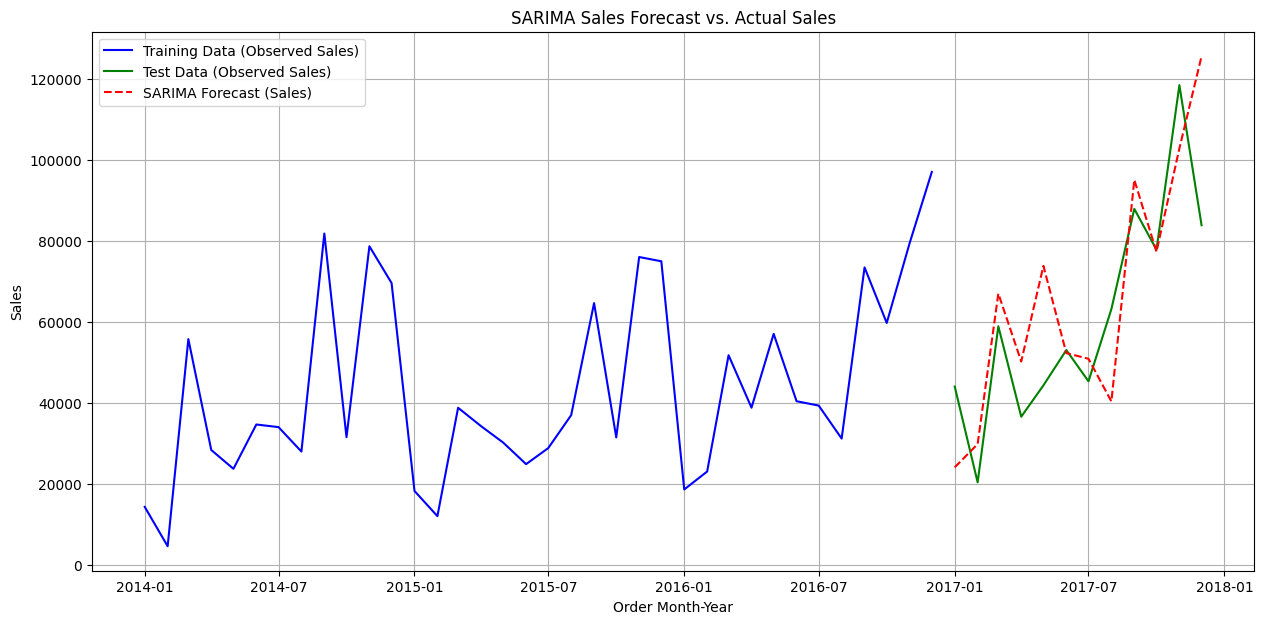

In [16]:
# 4. Make Predictions on the Test Set
start_index = len(train_data)
end_index = len(df_monthly) - 1
predictions_log = results.predict(start=start_index, end=end_index)

# Convert log predictions back to original scale (Sales)
predictions_sales = np.exp(predictions_log)
# Get observed sales (original scale) for the test period
observed_sales = np.exp(test_data)

# 5. Visualize Actual vs. Predicted Sales
plt.figure(figsize=(15, 7))
plt.plot(np.exp(train_data), label='Training Data (Observed Sales)', color='blue')
plt.plot(observed_sales, label='Test Data (Observed Sales)', color='green')
plt.plot(predictions_sales, label='SARIMA Forecast (Sales)', color='red', linestyle='--')
plt.title('SARIMA Sales Forecast vs. Actual Sales')
plt.xlabel('Order Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

Little strange about the sudden drop-off between train and test but this actually exists. Seems like our predictions are somewhat reasonable. Let's check out the residuals and check for normality/autocorrelation.


--- Residual Analysis ---


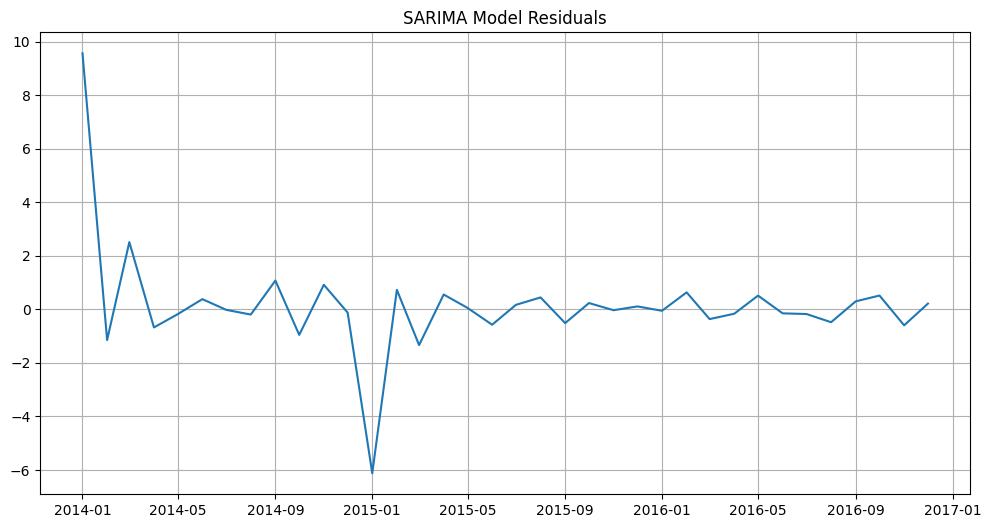

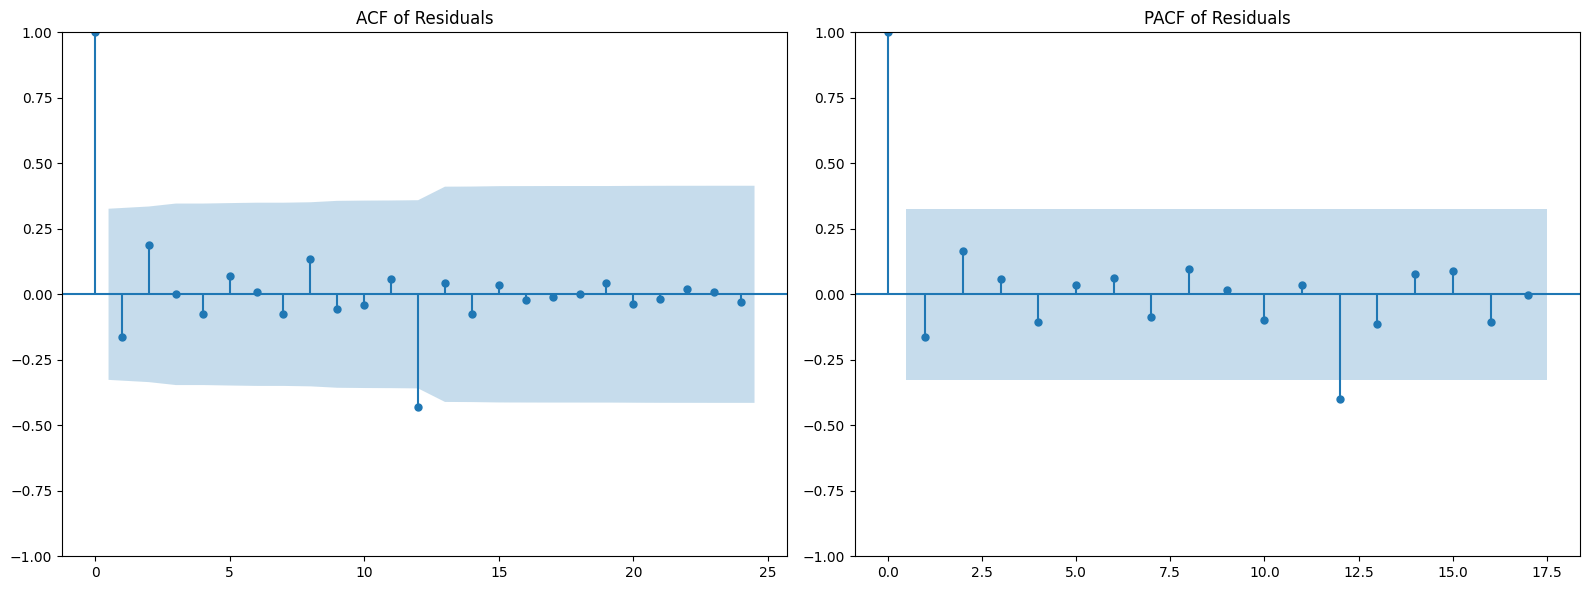


Ljung-Box test for residuals:
      lb_stat  lb_pvalue
12  15.134976   0.234138
24  16.167529   0.881934


In [17]:
import statsmodels.api as sm

print("\n--- Residual Analysis ---")
residuals = results.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('SARIMA Model Residuals')
plt.grid(True)
plt.show()
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(residuals, lags=24, ax=ax[0], title='ACF of Residuals')
plot_pacf(residuals, lags=17, ax=ax[1], title='PACF of Residuals')
plt.tight_layout()
plt.show()
# Ljung-Box test for white noise residuals
lb_test = sm.stats.acorr_ljungbox(residuals, lags=[12, 24], return_df=True)
print("\nLjung-Box test for residuals:")
print(lb_test)

# Weekly Aggregation

In [18]:
df_temp = df.copy()
df_temp.set_index("Order Date", inplace=True)

df_weekly = df_temp.resample("W").agg(
    Sales = ('Sales', 'sum'),
    Profit = ('Profit', 'sum'),
    Quantity = ('Quantity', 'sum')
)

df_weekly.head()

,Sales,Profit,Quantity
Order Date,,,
2014-01-05,324.044,-55.5549,13
2014-01-12,4599.572,1322.7434,49
2014-01-19,4509.127,398.8863,99
2014-01-26,3842.388,758.0377,108
2014-02-02,1642.310,239.5467,33


In [19]:
# Any nulls?
df_weekly.isnull().sum()

Sales       0
Profit      0
Quantity    0
dtype: int64

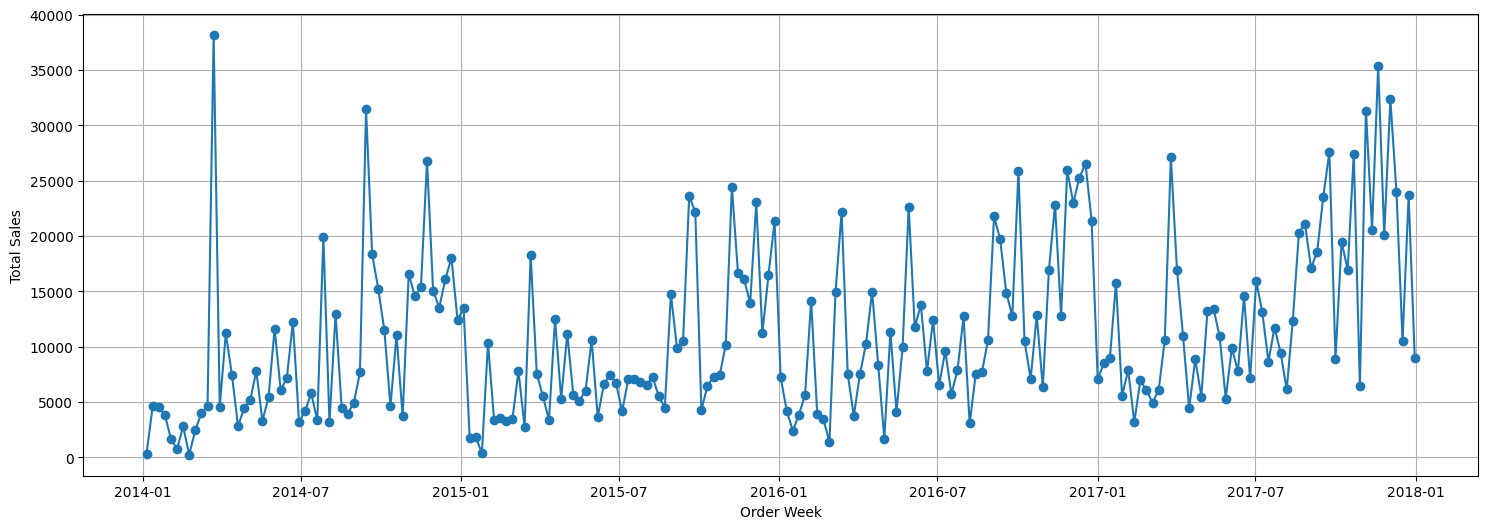

In [20]:
plt.figure(figsize=(18, 6))
plt.plot(df_weekly["Sales"], marker='o')
plt.xlabel("Order Week")
plt.ylabel("Total Sales")
plt.grid()

Variance is increasing so need to normalise the variance so this time let's use the boxcox transformation to explore this

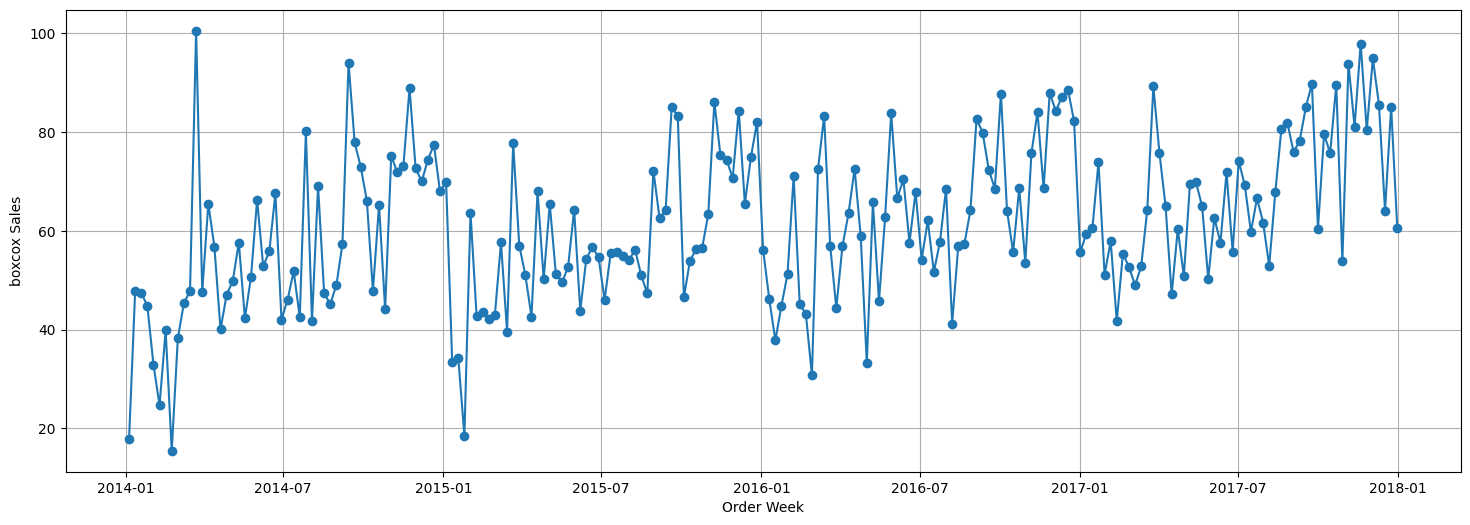

In [21]:
from scipy.stats import boxcox

df_weekly["boxcox_sales"], lambda_value = boxcox(df_weekly["Sales"] + 1)  # Adding 1 to avoid log(0)

plt.figure(figsize=(18, 6))
plt.plot(df_weekly["boxcox_sales"], marker='o')
plt.xlabel("Order Week")
plt.ylabel("boxcox Sales")
plt.grid()

Check for stationarity and determine differencing orders `d` and `D`

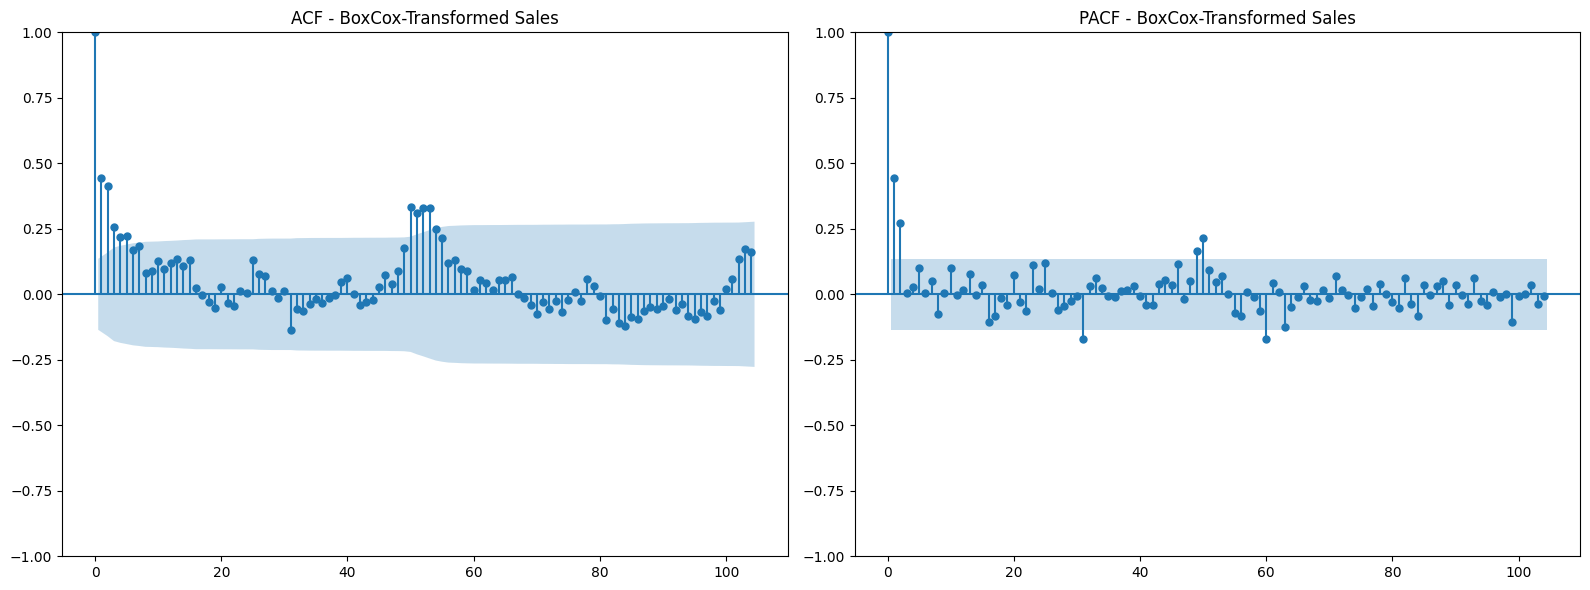

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(df_weekly['boxcox_sales'], lags=52*2, ax=ax[0], title='ACF - BoxCox-Transformed Sales')
plot_pacf(df_weekly['boxcox_sales'], lags=52*2, ax=ax[1], title='PACF - BoxCox-Transformed Sales')
plt.tight_layout()
plt.show()

Interpretation:
- "Slowly decaying ACF" $\rightarrow$ Requires non seasonal differencing. Often `d=1` is enough
- Jump around the 52 mark $\rightarrow$ Seasonal differencing required. Often use `D=1` and `s=52`.

Notes:
- `D` refers to how many times you subtract the observation from the previous **seasonal period**

Next steps:
- Apply differencing and re-plot ACF/PACF plots

In [23]:
# Perform seasonal differencing (D=1, s=52)
df_weekly["seasonal_diff_boxcox_sales"] = df_weekly["boxcox_sales"].diff(52)
# Perform non-seasonal differencing (d=1)
df_weekly["doubly_differenced_sales"] = df_weekly["seasonal_diff_boxcox_sales"].diff(1)

# Drop the NaN values introduced by differencing
# We expect the first 53 values will be NaN (52 seasonal, 1 non-seasonal)
plot_series_after_diff = df_weekly["seasonal_diff_boxcox_sales"].dropna()

print(f"Length of the doubly differenced series (after dropping NaNs): {len(plot_series_after_diff)}")
print("Head of the doubly differenced series:")
print(plot_series_after_diff.head())

Length of the doubly differenced series (after dropping NaNs): 157
Head of the doubly differenced series:
Order Date
2015-01-04    52.033844
2015-01-11   -14.375069
2015-01-18   -13.209097
2015-01-25   -26.247751
2015-02-01    30.702810
Freq: W-SUN, Name: seasonal_diff_boxcox_sales, dtype: float64


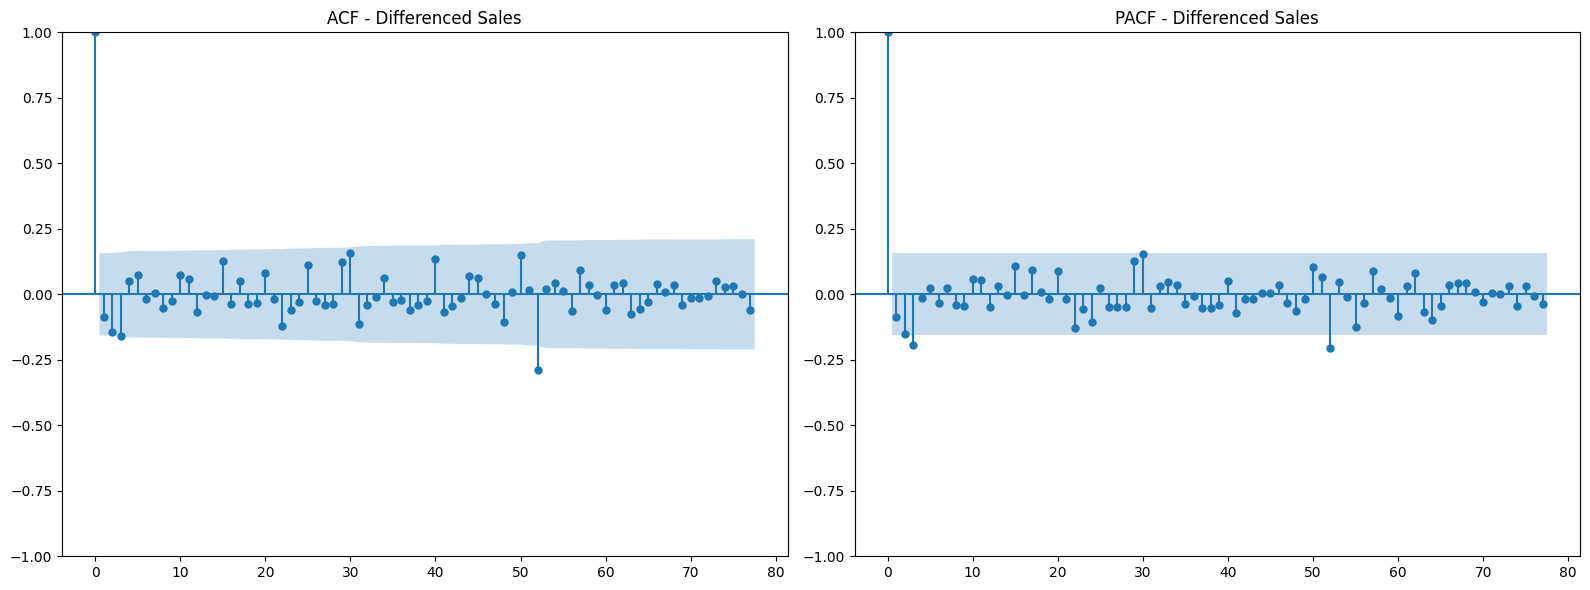

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(plot_series_after_diff, lags=77, ax=ax[0], title='ACF - Differenced Sales')
plot_pacf(plot_series_after_diff, lags=77, ax=ax[1], title='PACF - Differenced Sales')
plt.tight_layout()
plt.show()

This looks like white noise to me! This means the doubly differenced series is doing it's job. <br>
This means our sales time series is now stationary.

Next steps: <br>
Identify AR and MA orders `p, q, P, Q`

Tried to use auto_arima to determine parameters but had issues in installing a compatible version with my other packages.

In [25]:
# Typically, reserve the last 12 to 24 (1-2 seasonal cycles) months for testing
train_size = len(df_weekly) - 52
train_data = df_weekly['boxcox_sales'].iloc[:train_size]
test_data = df_weekly['boxcox_sales'].iloc[train_size:]

print(f"Train data length: {len(train_data)} weeks")
print(f"Test data length: {len(test_data)} weeks")

Train data length: 157 weeks
Test data length: 52 weeks


In [26]:
# From boxcox-transformed ACF/PACF plots, we see:
d = 1
s = 52
D = 1

p = 0 # No spikes outside of blue confidence interval (PACF)
q = 0 # No spikes outside of blue confidence interval (ACF)
P = 1 # spike at 52, want either (P=1, Q=0) or (P=0, Q=1)
Q = 0

order = (p, d, q)
seasonal_order = (P, D, Q, s)

In [27]:
sarima = SARIMAX(train_data,
                 order=order,
                 seasonal_order=seasonal_order,
                 freq='W'
)
results = sarima.fit(disp=False)
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       boxcox_sales   No. Observations:                  157
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 52)   Log Likelihood                -472.074
Date:                            Tue, 29 Jul 2025   AIC                            948.148
Time:                                    14:12:42   BIC                            953.437
Sample:                                01-05-2014   HQIC                           950.291
                                     - 01-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L52      -0.3166      0.131     -2.416      0.016      -0.573      -0.060
sigma2       486.7999     65.468   

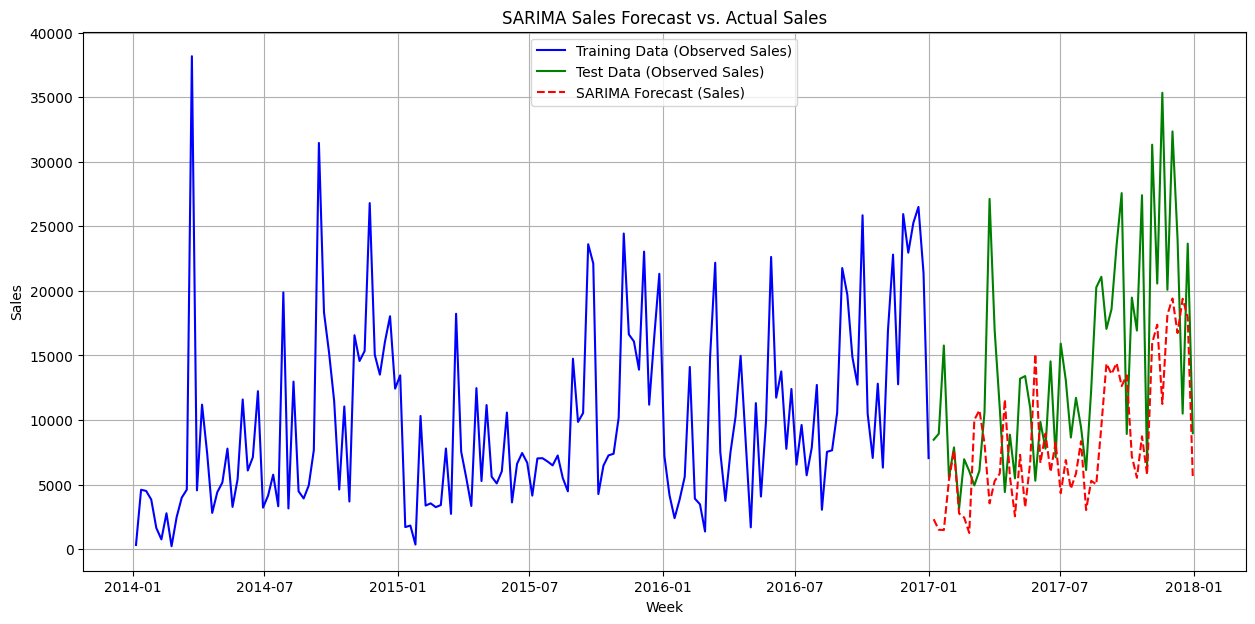

In [28]:
from scipy.special import inv_boxcox

start_index = len(train_data)
end_index = len(df_weekly) - 1
predictions_log = results.predict(start=start_index, end=end_index)

# Convert log predictions back to original scale (Sales)
predictions_sales = inv_boxcox(predictions_log, lambda_value)
# Get observed sales (original scale) for the test period
observed_sales = inv_boxcox(test_data, lambda_value)

# 5. Visualize Actual vs. Predicted Sales
plt.figure(figsize=(15, 7))
plt.plot(inv_boxcox(train_data, lambda_value), label='Training Data (Observed Sales)', color='blue')
plt.plot(observed_sales, label='Test Data (Observed Sales)', color='green')
plt.plot(predictions_sales, label='SARIMA Forecast (Sales)', color='red', linestyle='--')
plt.title('SARIMA Sales Forecast vs. Actual Sales')
plt.xlabel('Week')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


--- Residual Analysis ---


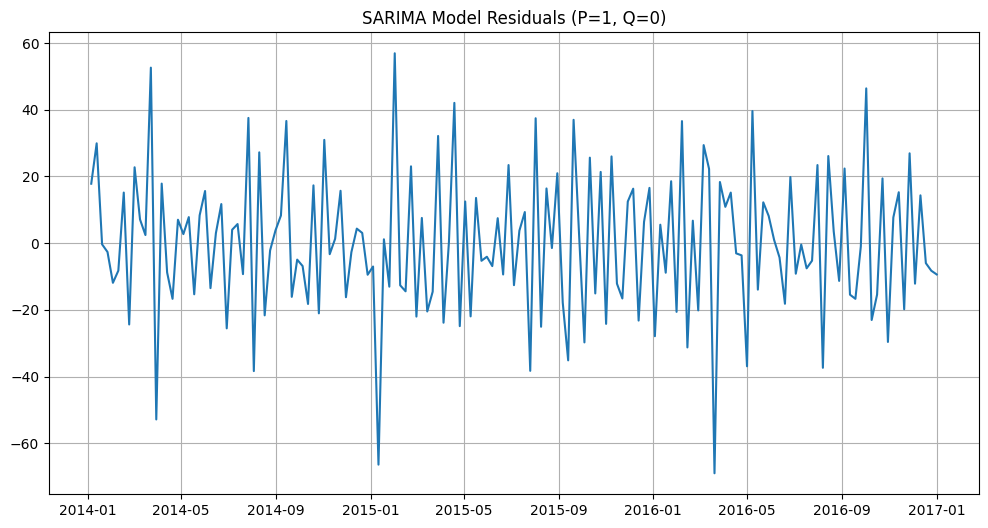

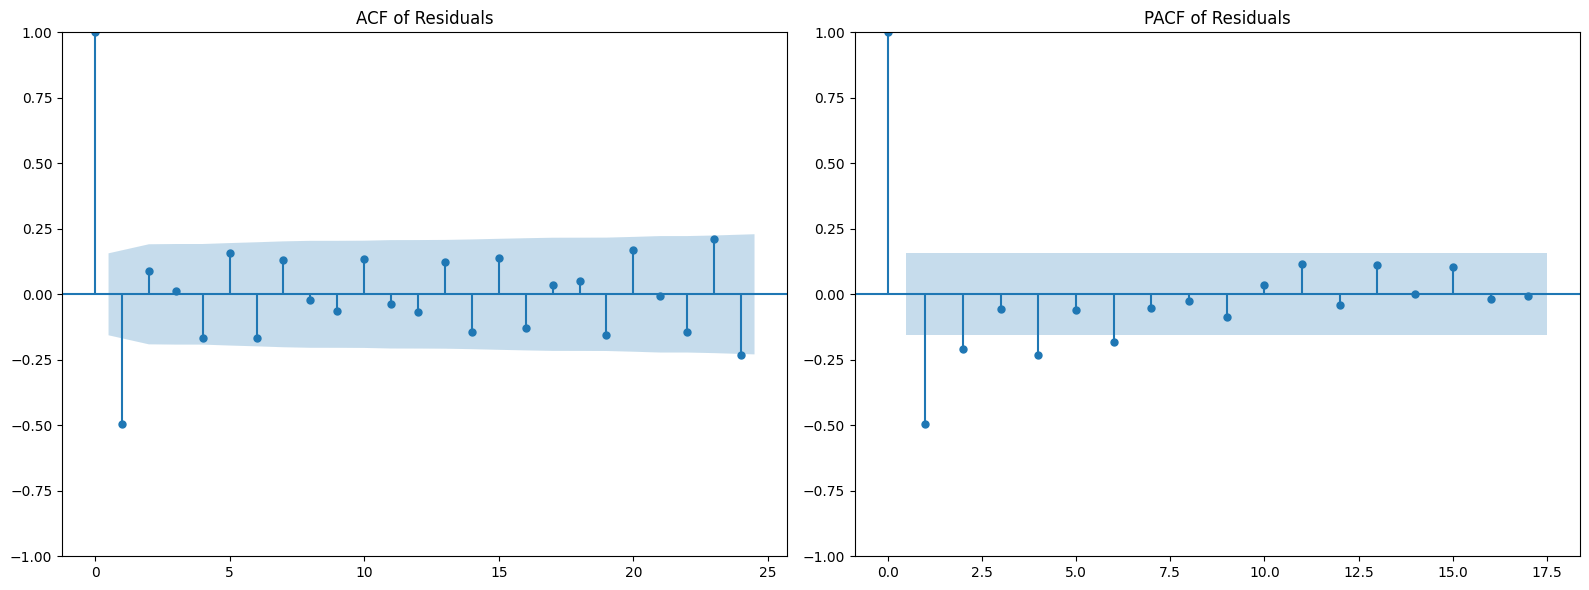


Ljung-Box test for residuals:
       lb_stat     lb_pvalue
12   61.705130  1.101506e-08
24  106.762534  2.063663e-12


In [29]:
print("\n--- Residual Analysis ---")
residuals = results.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('SARIMA Model Residuals (P=1, Q=0)')
plt.grid(True)
plt.show()
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(residuals, lags=24, ax=ax[0], title='ACF of Residuals')
plot_pacf(residuals, lags=17, ax=ax[1], title='PACF of Residuals')
plt.tight_layout()
plt.show()
# Ljung-Box test for white noise residuals
lb_test = sm.stats.acorr_ljungbox(residuals, lags=[12, 24], return_df=True)
print("\nLjung-Box test for residuals:")
print(lb_test)

In [30]:
P=0
Q=1
order = (p, d, q)
seasonal_order = (P, D, Q, s)

sarima = SARIMAX(train_data,
                 order=order,
                 seasonal_order=seasonal_order,
                 freq='W'
)
results = sarima.fit(disp=False)
print(results.summary())

c:\Users\jhenshaw\git\training\rdf\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                      SARIMAX Results                                       
Dep. Variable:                         boxcox_sales   No. Observations:                  157
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 52)   Log Likelihood                -472.073
Date:                              Tue, 29 Jul 2025   AIC                            948.146
Time:                                      14:12:46   BIC                            953.435
Sample:                                  01-05-2014   HQIC                           950.289
                                       - 01-01-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L52      -0.3571      0.191     -1.870      0.061      -0.731       0.017
sigma2       479.82

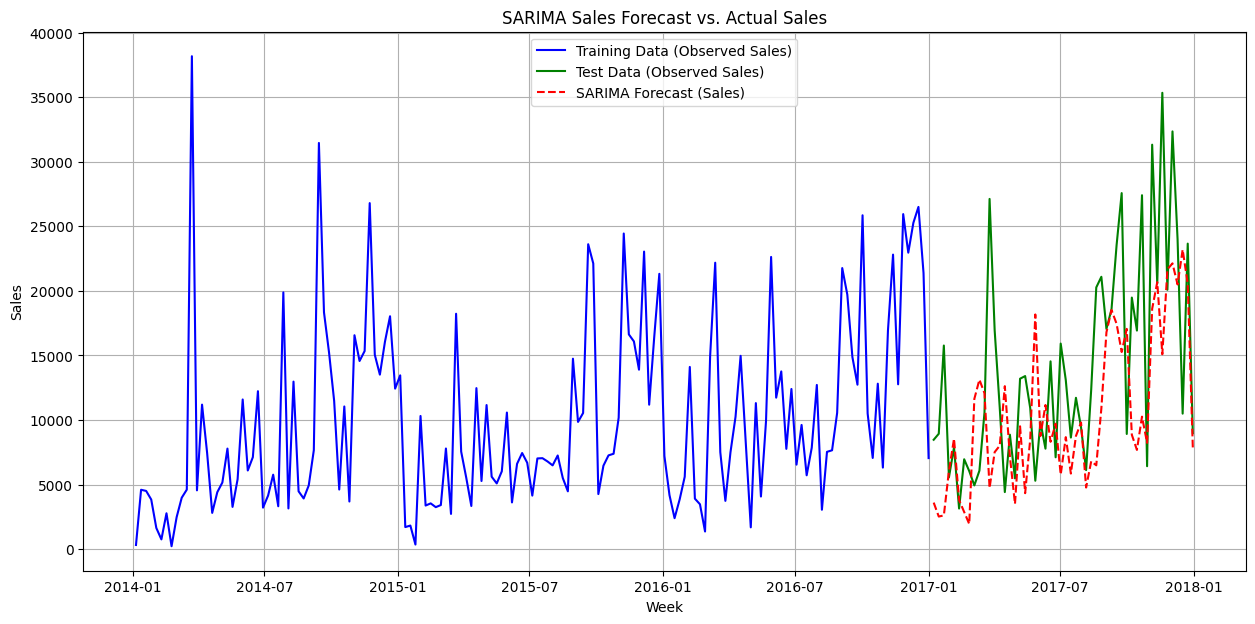

In [31]:
start_index = len(train_data)
end_index = len(df_weekly) - 1
predictions_log = results.predict(start=start_index, end=end_index)

# Convert log predictions back to original scale (Sales)
predictions_sales = inv_boxcox(predictions_log, lambda_value)
# Get observed sales (original scale) for the test period
observed_sales = inv_boxcox(test_data, lambda_value)

# 5. Visualize Actual vs. Predicted Sales
plt.figure(figsize=(15, 7))
plt.plot(inv_boxcox(train_data, lambda_value), label='Training Data (Observed Sales)', color='blue')
plt.plot(observed_sales, label='Test Data (Observed Sales)', color='green')
plt.plot(predictions_sales, label='SARIMA Forecast (Sales)', color='red', linestyle='--')
plt.title('SARIMA Sales Forecast vs. Actual Sales')
plt.xlabel('Week')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


--- Residual Analysis ---


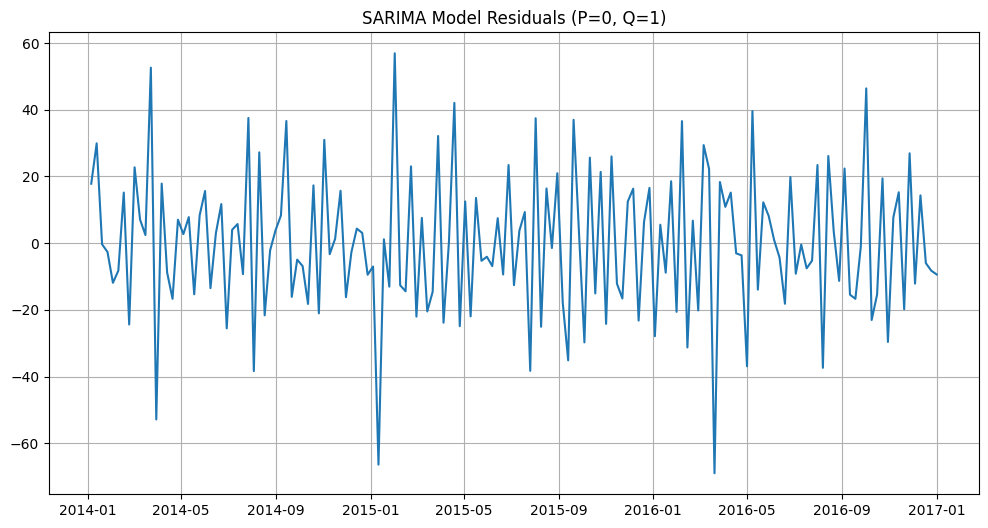

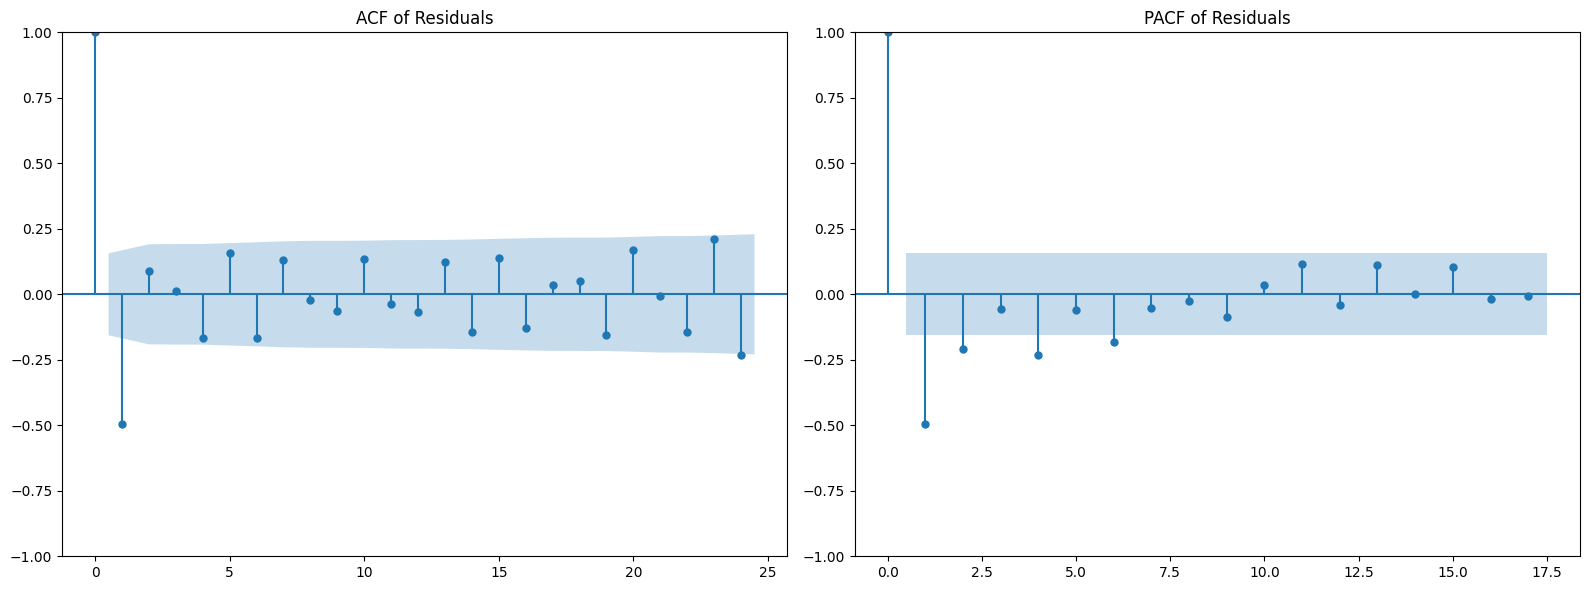


Ljung-Box test for residuals:
       lb_stat     lb_pvalue
12   61.709611  1.099426e-08
24  106.763855  2.062575e-12


In [ ]:
print("\n--- Residual Analysis ---")
residuals = results.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('SARIMA Model Residuals (P=0, Q=1)')
plt.grid(True)
plt.show()
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(residuals, lags=24, ax=ax[0], title='ACF of Residuals')
plot_pacf(residuals, lags=17, ax=ax[1], title='PACF of Residuals')
plt.tight_layout()
plt.show()
# Ljung-Box test for white noise residuals
lb_test = sm.stats.acorr_ljungbox(residuals, lags=[12, 24], return_df=True)
print("\nLjung-Box test for residuals:")
print(lb_test)

Both models are feasible. Let's see if we can split to category now.

# Category Models

## Furniture

In [36]:
df["Category"].unique()

array(['Furniture', 'Office Supplies', 'Technology'], dtype=object)

## Office Supplies

## Technology